### 1. Вопросы

1. Аналитическое решение для линейной регрессии

Линейная регрессия имеет вид:

y = Xw + e, где:

y - Вектор целевых значений (размерность m×1),

X - Матрица признаков (размерность m×n, где m — количество наблюдений, а n — количество признаков),

w - Вектор коэффициентов (размерность n×1)

e - Вектор ошибок (размерность m×1)

Веса линейной регрессии находятся из принципа минимизации наименьших квадратов:

![Формула](data/1a.png)

2. Регуляризация L1 и L2

Добавление регуляризаций L1 и L2 к функции потерь влияет на процесс оптимизации и характеристики получаемого решения:

Регуляризация L1 (Lasso)
- Стимулирует разреженность весов (многие коэффициенты становятся равны нулю)
- Подходит для отбора наиболее значимых признаков
- Применяется, когда важно уменьшить количество активных признаков

Регуляризация L2 (Ridge)
- Уменьшает веса, но не зануляет их
- Делает модель менее чувствительной к небольшим изменениям в данных
- Применяется, когда важна стабильность модели, в задачах с высоким уровнем корреляции между признаками.

![Оптимизационная задача с регуляризацией](data/1b.png)

3. Регуляризация L1, отбор признаков

L1-регуляризация (Lasso) часто используется для выбора признаков, потому что она создаёт разреженность весов — многие коэффициенты становятся точно равны нулю, вследствие чего, удаляются неинформативные признаки

![L1-регуляризация (Lasso)](data/1c.png)

4. Подгонка нелинейных зависимостей

Чтобы использовать линейные модели (линейная регрессия, гребневая регрессия, кластерная регрессия...) для аппроксимации (приближения) нелинейных зависимостей, можно применять несколько методов:
- Добавить полиномиальные признаки (PolynomialFeatures) - расширяет исходные признаки, добавляя их степени и взаимодействия
- Использовать сплайны (SplineTransformer) - разбивает диапазон значений признаков на интервалы и аппроксимирует их с помощью кусочно-полиномиальных функций
- Использовать ядерные методы (например, KernelRidge) - неявно переводит данные в более высокое пространство, где зависимость уже становится линейной

### 2. Введение

In [221]:
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
import warnings

In [222]:
df = pd.read_json('data/train.json')
df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,"Spacious 1 Bedroom 1 Bathroom in Williamsburg!Apartment Features:- Renovated Eat in Kitchen With Dishwasher- Renovated Bathroom- Beautiful Hardwood Floors- Lots of Sunlight- Great Closet Space- Freshly Painted- Heat and Hot Water Included- Live in Super Nearby L, J, M & G Trains !<br /><br />Contact Information:Kenneth BeakExclusive AgentC: 064-692-8838Email: kagglemanager@renthop.com, Text or Email to schedule a private viewing!<br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><p><a website_redacted",145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Dishwasher, Hardwood Floors, Dogs Allowed, Cats Allowed]",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,"[https://photos.renthop.com/2/7170325_3bb5ac84a5a10227b17b273e79bd77b4.jpg, https://photos.renthop.com/2/7170325_a29a17a771ee6af213966699b05c8ea2.jpg, https://photos.renthop.com/2/7170325_149a898e8760cac1cad56e30cfe98baa.jpg, https://photos.renthop.com/2/7170325_f74a43d781bcc3c5588e61dd47de81ba.jpg, https://photos.renthop.com/2/7170325_e677d9d249ac99abe01aa5454c6e9f59.jpg, https://photos.renthop.com/2/7170325_960ea0e180bf2f15467b68b455db6172.jpg, https://photos.renthop.com/2/7170325_cbc1b8437155dbf7f5d63b3a0b5a45a3.jpg, https://photos.renthop.com/2/7170325_9a9f2adc2ce922e1d5394727efdf64bb.jpg, https://photos.renthop.com/2/7170325_aae2a39d536103eebb282775fab1c315.jpg, https://photos.renthop.com/2/7170325_cd290d0051b9f08e3482195dcbf6b5a6.jpg, https://photos.renthop.com/2/7170325_a2b599da7880eea1edd10c4b04250dc1.jpg, https://photos.renthop.com/2/7170325_6b83fa82d662bcb09733ac3a8a107113.jpg]",2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,"BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind yourself and your home in the center of it all. Steps from Grand Central Station, at the epicenter of Manhattan, The Centra combines convenience and luxury to create a perfectly balanced living experience. Offering newly renovated over sized apartment layouts.<br /><br />Full Time DoormanElevatorNewly Renovated HallwaysLaundry in BuildingOn-Site Parking Garage<br /><br />I operate with the utmost care and integrity. The client is my #1 priority. Contact me for a viewing of the great apartment, I'm more than confident we'll find a place for you to call home.Call/Text Keon: Email: If you require a move within 30 days write ""URGENT"" in the subject email or text message to be taken with high priority.<br /><br />One Month Free - net effective rent listed<p><a website_redacted",East 44th,"[Doorman, Elevator, Laundry in Building, Dishwasher, Hardwood Floors, No Fee]",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,"[https://photos.renthop.com/2/7092344_7663c19af02c46104bc4c569f7162ae0.jpg, https://photos.renthop.com/2/7092344_8287349abe511d195a7b6129bf24af0e.jpg, https://photos.renthop.com/2/7092344_e9e6a2b7aa95aa7564fe3318cadcf4e7.jpg, https://photos.renthop.com/2/7092344_d51ee4b92fd9246633f93afe6e86d8f0.jpg, https://photos.renthop.com/2/7092344_f0573fa184ca130b1b6000f2fa90511c.jpg, https://photos.renthop.com/2/7092344_b2a62f769a59a317b0a243000db46fd0.jpg]",3800,230 East 44th,low
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,"**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**Looking for the perfect apartment in Midtown East - Sutton Place? Come check out the beautiful apartment in this prime location! **Mid 50's and 1st Ave** Elevator Building with 24-hour doorman, laundry room, and bike room!LARGE living space with King Bedroom!Beautiful large kitchen with stainless steel appliances including dishwasher! Stunning modern bathroom! Ample amount of closet space throughout entire apartment, and enough space to fit everything you need and more! Apartment i

### 3. Вводный анализ данных

In [224]:
# for index in df.index:
#     feature_value = df.at[index, 'features']
#     cleaned_value = str(feature_value).replace('[', '').replace(']', '').replace("'", '').replace('"', '').replace(' ', '')
#     df.at[index, 'features'] = cleaned_value
# 
# features_list = []
# features = df['features']
# for row in features:
#     for feature in row.split(','):
#         features_list.append(feature)
# 
# print(features_list[:10])

In [225]:
features = df['features']
features_list = [feature_name for feature in features for feature_name in feature]
print(features_list[:20])

['Dining Room', 'Pre-War', 'Laundry in Building', 'Dishwasher', 'Hardwood Floors', 'Dogs Allowed', 'Cats Allowed', 'Doorman', 'Elevator', 'Laundry in Building', 'Dishwasher', 'Hardwood Floors', 'No Fee', 'Doorman', 'Elevator', 'Laundry in Building', 'Laundry in Unit', 'Dishwasher', 'Hardwood Floors', 'Doorman']


In [226]:
print(f'Unique values: {len(set(features_list))}')

Unique values: 1556


In [227]:
counter = Counter(features_list)
counter.most_common(20)

[('Elevator', 25915),
 ('Cats Allowed', 23540),
 ('Hardwood Floors', 23527),
 ('Dogs Allowed', 22035),
 ('Doorman', 20898),
 ('Dishwasher', 20426),
 ('No Fee', 18062),
 ('Laundry in Building', 16344),
 ('Fitness Center', 13252),
 ('Pre-War', 9148),
 ('Laundry in Unit', 8738),
 ('Roof Deck', 6542),
 ('Outdoor Space', 5268),
 ('Dining Room', 5136),
 ('High Speed Internet', 4299),
 ('Balcony', 2992),
 ('Swimming Pool', 2730),
 ('Laundry In Building', 2593),
 ('New Construction', 2559),
 ('Terrace', 2283)]

In [228]:
most_common = [name for name, count in counter.most_common(20)]

result_df = df[['bathrooms', 'bedrooms', 'interest_level', 'features']].copy()

for feature in most_common:
    result_df[feature] = result_df['features'].apply(lambda x: 1 if feature in x else 0)

result_df.head()

,bathrooms,bedrooms,interest_level,features,Elevator,Cats Allowed,Hardwood Floors,Dogs Allowed,Doorman,Dishwasher,...,Laundry in Unit,Roof Deck,Outdoor Space,Dining Room,High Speed Internet,Balcony,Swimming Pool,Laundry In Building,New Construction,Terrace
4,1.0,1,medium,"[Dining Room, Pre-War, Laundry in Building, Dishwasher, Hardwood Floors, Dogs Allowed, Cats Allowed]",0,1,1,1,0,1,...,0,0,0,1,0,0,0,0,0,0
6,1.0,2,low,"[Doorman, Elevator, Laundry in Building, Dishwasher, Hardwood Floors, No Fee]",1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
9,1.0,2,medium,"[Doorman, Elevator, Laundry in Building, Laundry in Unit, Dishwasher, Hardwood Floors]",1,0,1,0,1,1,...,1,0,0,0,0,0,0,0,0,0
10,1.5,3,medium,[],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,1.0,0,low,"[Doorman, Elevator, Fitness Center, Laundry in Building]",1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [260]:
result_df['interest_level'] = result_df['interest_level'].replace({'low': 0, 'medium': 1, 'high': 2}).astype(int)
if 'features' in result_df.columns:
    result_df.drop(columns=['features'], inplace=True)
if 'price' not in result_df.columns:
    result_df['price'] = df['price']
result_df.head()

,bathrooms,bedrooms,interest_level,Elevator,Cats Allowed,Hardwood Floors,Dogs Allowed,Doorman,Dishwasher,No Fee,...,Roof Deck,Outdoor Space,Dining Room,High Speed Internet,Balcony,Swimming Pool,Laundry In Building,New Construction,Terrace,price
4,1.0,1,1,0,1,1,1,0,1,0,...,0,0,1,0,0,0,0,0,0,2400
6,1.0,2,0,1,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,3800
9,1.0,2,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,3495
10,1.5,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3000
15,1.0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2795


In [230]:
df_copy = result_df.copy()

lower_percentile = result_df['price'].quantile(0.01)
upper_percentile = result_df['price'].quantile(0.99)

result_df = result_df[(result_df['price'] > lower_percentile) & (result_df['price'] < upper_percentile)]

In [231]:
# result_df.to_csv('data/result.csv')

### 4. Реализация моделей — Линейная регрессия

In [232]:
class MyLinearRegression:
    def __init__(self, method='sgd', learning_rate=0.001, epochs=100, penalty=None, lambda_=1.0):
        self.method = method  # Метод обучения
        self.learning_rate = learning_rate  # Скорость обучения
        self.epochs = epochs  # Количество эпох (итераций обучения)
        self.weights = None  # Веса модели
        self.penalty = penalty
        self.lambda_ = lambda_
        
    def fit(self, X, y):

        X = np.c_[np.ones(X.shape[0]), X] # Добавляем bias (столбец единиц) (intercept)
        y = y.values.reshape(-1, 1)  # Преобразуем y в вертикальный вектор

        if self.method == 'analytic':
            I = np.eye(X.shape[1])  # Единичная матрица размером с X.T @ X
            if self.penalty == 'l2':
                self.weights = np.linalg.inv(X.T @ X + self.lambda_ * I) @ X.T @ y
            else:
                self.weights = np.linalg.inv(X.T @ X) @ X.T @ y

        elif self.method == 'sgd':
            
            m, n = X.shape
            self.weights = np.zeros((n, 1))  # Теперь учитываем bias
            
            for _ in range(self.epochs):
                for i in range(m):
                    random_index = np.random.randint(m)  # Выбираем случайный индекс
                    xi = X[random_index:random_index + 1]  # Один случайный пример
                    yi = y[random_index:random_index + 1]
                    gradient = 2 * xi.T @ (xi @ self.weights - yi)  # Градиент
                    
                    if self.penalty == 'l2':  # Ridge (L2-регуляризация)
                        gradient += (2 * self.lambda_) * self.weights

                    elif self.penalty == 'l1':  # Lasso (L1-регуляризация)
                        gradient += self.lambda_ * np.sign(self.weights)
            
                    elif self.penalty == 'elasticnet':  # ElasticNet (L1 + L2)
                        l1_ratio = 0.5  #  Баланс L1/L2
                        gradient += (1 - l1_ratio) * (2 * self.lambda_ * self.weights) + l1_ratio * (self.lambda_ * np.sign(self.weights))
                        
                    self.weights -= self.learning_rate * gradient  # Обновляем веса

        elif self.method == 'bgd':
            m, n = X.shape
            self.weights = np.zeros((n, 1))
            for _ in range(self.epochs):
                gradient = (2 / m) * X.T @ (X @ self.weights - y)  # Градиент
                if self.penalty == 'l2':  # Ridge (L2-регуляризация)
                    gradient += (2 * self.lambda_) * self.weights

                elif self.penalty == 'l1':  # Lasso (L1-регуляризация)
                    gradient += self.lambda_ * np.sign(self.weights)
        
                elif self.penalty == 'elasticnet':  # ElasticNet (L1 + L2)
                    l1_ratio = 0.5  #  Баланс L1/L2
                    gradient += (1 - l1_ratio) * (2 * self.lambda_ * self.weights) + l1_ratio * (self.lambda_ * np.sign(self.weights))
        
                self.weights -= self.learning_rate * gradient  # Обновление весов
                
        else:
            raise ValueError("Incorrect method: use 'sgd' or 'analytic' or 'bgd'")

    def predict(self, X):
        X = np.c_[np.ones(X.shape[0]), X]  # Добавляем bias
        return (X @ self.weights).ravel()  # Вычисляем прогноз

In [233]:
X = result_df.drop(['price'], axis=1)
y = result_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [234]:
def my_r2_score(y_true, y_pred):
    SS_res = np.sum((y_true - y_pred) ** 2)
    SS_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - SS_res / SS_tot

def my_mean_absolute_error(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / len(y_true)

def my_root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.sum((y_true - y_pred) ** 2) / len(y_true))

In [235]:
model = MyLinearRegression(method='sgd', learning_rate=0.01, epochs=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('SGD Model:')
print(f'R2: {my_r2_score(y_test, y_pred)}')
print(f'MAE: {my_mean_absolute_error(y_test, y_pred)}')
print(f'RMSE: {my_root_mean_squared_error(y_test, y_pred)}')

SGD Model:
R2: 0.5631358429582561
MAE: 704.2080580063842
RMSE: 1061.519432152258


In [236]:
model = MyLinearRegression(method='bgd', learning_rate=0.001, epochs=10000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print('BGD Model:')
print(f'R2: {my_r2_score(y_test, y_pred)}')
print(f'MAE: {my_mean_absolute_error(y_test, y_pred)}')
print(f'RMSE: {my_root_mean_squared_error(y_test, y_pred)}')

BGD Model:
R2: 0.6152648632253803
MAE: 689.5290390253145
RMSE: 996.1750659686721


In [237]:
model = MyLinearRegression(method='analytic', learning_rate=0.001, epochs=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print('Analytic Model:')
print(f'R2: {my_r2_score(y_test, y_pred)}')
print(f'MAE: {my_mean_absolute_error(y_test, y_pred)}')
print(f'RMSE: {my_root_mean_squared_error(y_test, y_pred)}')

Analytic Model:
R2: 0.616495015905854
MAE: 689.0101553085188
RMSE: 994.5812050999856


In [238]:
sk = LinearRegression()
sk.fit(X_train, y_train)
y_pred = sk.predict(X_test)

print('Linear Model (sklearn):')
print(f'R2: {r2_score(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')

Linear Model (sklearn):
R2: 0.6164950159058543
MAE: 689.0101553085177
RMSE: 994.5812050999851


In [239]:
result_R2 = pd.DataFrame(columns=['model', 'train', 'test'])
result_MAE = pd.DataFrame(columns=['model', 'train', 'test'])
result_RMSE = pd.DataFrame(columns=['model', 'train', 'test'])

In [240]:
def write_metrics(model, model_name):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    if model_name not in result_R2['model'].values:
        result_R2.loc[len(result_R2)] = [model_name, r2_train, r2_test]
        result_MAE.loc[len(result_MAE)] = [model_name, mae_train, mae_test]
        result_RMSE.loc[len(result_RMSE)] = [model_name, rmse_train, rmse_test]
    
def print_metrics():
    print('Results R2:', result_R2, sep='\n', end='\n\n')
    print('Results MAE:', result_MAE, sep='\n', end='\n\n')
    print('Results RMSE:', result_RMSE, sep='\n')

In [241]:
linreg = LinearRegression()
write_metrics(linreg, 'linereg default')

In [242]:
print_metrics()

Results R2:
             model     train      test
0  linereg default  0.602062  0.616495

Results MAE:
             model       train        test
0  linereg default  687.030471  689.010155

Results RMSE:
             model       train        test
0  linereg default  996.991413  994.581205


### 5. Реализация регуляризованных моделей — Ridge, Lasso, ElasticNet

In [243]:
penalty = ['l1', 'l2', 'elasticnet']
for p in penalty:
    model = MyLinearRegression(method='sgd', learning_rate=0.01, epochs=100, penalty=p)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'SGD Model (penalty {p}):')
    print(f'R2: {my_r2_score(y_test, y_pred)}')
    print(f'MAE: {my_mean_absolute_error(y_test, y_pred)}')
    print(f'RMSE: {my_root_mean_squared_error(y_test, y_pred)}')

SGD Model (penalty l1):
R2: 0.6065372014485637
MAE: 713.8898371415563
RMSE: 1007.4107480737356
SGD Model (penalty l2):
R2: 0.3784901359351861
MAE: 867.3052820022327
RMSE: 1266.1313277632232
SGD Model (penalty elasticnet):
R2: 0.02387607454552776
MAE: 1152.5067731192773
RMSE: 1586.745300086333


In [244]:
models = {'Ridge default': Ridge(), 'Lasso default': Lasso(), 'ElasticNet default': ElasticNet()}
for model_name, model in models.items():
    write_metrics(model, model_name)
    
print_metrics()

Results R2:
                model     train      test
0     linereg default  0.602062  0.616495
1       Ridge default  0.602062  0.616493
2       Lasso default  0.601920  0.616227
3  ElasticNet default  0.470794  0.475841

Results MAE:
                model       train        test
0     linereg default  687.030471  689.010155
1       Ridge default  687.026383  689.007983
2       Lasso default  686.455762  688.619712
3  ElasticNet default  777.012834  785.570792

Results RMSE:
                model        train         test
0     linereg default   996.991413   994.581205
1       Ridge default   996.991419   994.584120
2       Lasso default   997.169344   994.928759
3  ElasticNet default  1149.730017  1162.750102


### 6. Нормализация признаков

Нормализация: Преобразует данные так, чтобы они имели фиксированный диапазон, например, от 0 до 1. Это полезно, когда важно сохранить пропорции между признаками

Стандартизация: Преобразует данные так, чтобы они имели нулевое среднее значение и стандартное отклонение равное 1

Нормализация обязательна в случаях, когда алгоритм использует метрики расстояния, градиентный спуск или регуляризацию, чувствительную к масштабу признаков (например, в KNN, SVM, линейных моделях с регуляризацией)

Нормализация не обязательна в случае с деревьями решений и другими алгоритмами, которые не зависят от масштаба признаков (например, случайный лес, градиентный бустинг)

![](data/6a.png)

In [245]:
def my_min_max_scaler(X):
    return (X - X.min()) / (X.max() - X.min())

def my_standard_scaler(X):
    return (X - X.mean()) / X.std()

In [246]:
X_copy = X.copy()
X_normal = my_min_max_scaler(X_copy)
X_normal_sk = MinMaxScaler().fit_transform(X_copy)
print(X_copy.iloc[:3, :5])
print(X_normal.iloc[:3, :5])
print(pd.DataFrame(X_normal_sk, columns=X.columns).iloc[:3, :5])

   bathrooms  bedrooms  interest_level  Elevator  Cats Allowed
4        1.0         1               1         0             1
6        1.0         2               0         1             0
9        1.0         2               1         1             0
   bathrooms  bedrooms  interest_level  Elevator  Cats Allowed
4        0.1     0.125             0.5       0.0           1.0
6        0.1     0.250             0.0       1.0           0.0
9        0.1     0.250             0.5       1.0           0.0
   bathrooms  bedrooms  interest_level  Elevator  Cats Allowed
0        0.1     0.125             0.5       0.0           1.0
1        0.1     0.250             0.0       1.0           0.0
2        0.1     0.250             0.5       1.0           0.0


In [247]:
X_copy = X.copy()
X_standard = my_standard_scaler(X_copy)
X_standard_sk = StandardScaler().fit_transform(X_copy)
print(X_copy.iloc[:3, :5])
print(X_standard.iloc[:3, :5])
print(pd.DataFrame(X_standard_sk, columns=X.columns).iloc[:3, :5])

   bathrooms  bedrooms  interest_level  Elevator  Cats Allowed
4        1.0         1               1         0             1
6        1.0         2               0         1             0
9        1.0         2               1         1             0
   bathrooms  bedrooms  interest_level  Elevator  Cats Allowed
4  -0.427285 -0.485070        1.007835 -1.051083       1.04383
6  -0.427285  0.422955       -0.610022  0.951380      -0.95799
9  -0.427285  0.422955        1.007835  0.951380      -0.95799
   bathrooms  bedrooms  interest_level  Elevator  Cats Allowed
0  -0.427289 -0.485075        1.007846 -1.051094      1.043841
1  -0.427289  0.422959       -0.610029  0.951390     -0.958000
2  -0.427289  0.422959        1.007846  0.951390     -0.958000


### 7. Подгонка моделей с нормализацией

In [248]:
X_train, X_test, y_train, y_test = train_test_split(X_normal_sk, y, test_size=0.2, random_state=21)
models = {'Linear MinMaxScaler': LinearRegression(), 'Ridge MinMaxScaler': Ridge(), 'Lasso MinMaxScaler': Lasso(), 'ElasticNet MinMaxScaler': ElasticNet()}
for model_name, model in models.items():
    write_metrics(model, model_name)
    
print_metrics()

Results R2:
                     model     train      test
0          linereg default  0.602062  0.616495
1            Ridge default  0.602062  0.616493
2            Lasso default  0.601920  0.616227
3       ElasticNet default  0.470794  0.475841
4      Linear MinMaxScaler  0.602062  0.616495
5       Ridge MinMaxScaler  0.602024  0.616333
6       Lasso MinMaxScaler  0.601729  0.615800
7  ElasticNet MinMaxScaler  0.138556  0.140066

Results MAE:
                     model        train         test
0          linereg default   687.030471   689.010155
1            Ridge default   687.026383   689.007983
2            Lasso default   686.455762   688.619712
3       ElasticNet default   777.012834   785.570792
4      Linear MinMaxScaler   687.030471   689.010155
5       Ridge MinMaxScaler   687.156337   689.224459
6       Lasso MinMaxScaler   686.642636   689.032914
7  ElasticNet MinMaxScaler  1042.968244  1056.130500

Results RMSE:
                     model        train         test
0     

In [249]:
X_train, X_test, y_train, y_test = train_test_split(X_standard_sk, y, test_size=0.2, random_state=21)
models = {'Linear StandardScaler': LinearRegression(), 'Ridge StandardScaler': Ridge(), 'Lasso StandardScaler': Lasso(), 'ElasticNet StandardScaler': ElasticNet()}
for model_name, model in models.items():
    write_metrics(model, model_name)
    
print_metrics()

Results R2:
                        model     train      test
0             linereg default  0.602062  0.616495
1               Ridge default  0.602062  0.616493
2               Lasso default  0.601920  0.616227
3          ElasticNet default  0.470794  0.475841
4         Linear MinMaxScaler  0.602062  0.616495
5          Ridge MinMaxScaler  0.602024  0.616333
6          Lasso MinMaxScaler  0.601729  0.615800
7     ElasticNet MinMaxScaler  0.138556  0.140066
8       Linear StandardScaler  0.602062  0.616495
9        Ridge StandardScaler  0.602062  0.616495
10       Lasso StandardScaler  0.602038  0.616399
11  ElasticNet StandardScaler  0.564929  0.576141

Results MAE:
                        model        train         test
0             linereg default   687.030471   689.010155
1               Ridge default   687.026383   689.007983
2               Lasso default   686.455762   688.619712
3          ElasticNet default   777.012834   785.570792
4         Linear MinMaxScaler   687.030471  

### 8. Модели переобучения

In [250]:
warnings.filterwarnings("ignore", category=UserWarning)

X_poly = result_df[['bathrooms', 'bedrooms', 'interest_level']]
y_poly = result_df['price']

X_poly = StandardScaler().fit_transform(X_poly)
X_poly = PolynomialFeatures(degree=10).fit_transform(X_poly)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=21)

models = {'Linear Polynomial': LinearRegression(), 'Ridge Polynomial': Ridge(), 'Lasso Polynomial': Lasso(), 'ElasticNet Polynomial': ElasticNet()}
for model_name, model in models.items():
    write_metrics(model, model_name)
    
print_metrics()

Results R2:
                        model     train          test
0             linereg default  0.602062      0.616495
1               Ridge default  0.602062      0.616493
2               Lasso default  0.601920      0.616227
3          ElasticNet default  0.470794      0.475841
4         Linear MinMaxScaler  0.602062      0.616495
5          Ridge MinMaxScaler  0.602024      0.616333
6          Lasso MinMaxScaler  0.601729      0.615800
7     ElasticNet MinMaxScaler  0.138556      0.140066
8       Linear StandardScaler  0.602062      0.616495
9        Ridge StandardScaler  0.602062      0.616495
10       Lasso StandardScaler  0.602038      0.616399
11  ElasticNet StandardScaler  0.564929      0.576141
12          Linear Polynomial  0.576636  -6129.088490
13           Ridge Polynomial  0.578992 -13177.867996
14           Lasso Polynomial  0.574542      0.574232
15      ElasticNet Polynomial  0.556844      0.543706

Results MAE:
                        model        train         test


In [266]:
result_R2['train'] = result_R2['train'].round(6)

### 9. Нативные модели

In [267]:
mean_price = np.mean(y)
median_price = np.median(y)

native = {'Native mean': mean_price, 'Native Median': median_price}

for model_name, native in native.items():
    y_train_pred = np.full_like(y_train, native)
    y_test_pred = np.full_like(y_test, native)
    
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    if model_name not in result_R2['model'].values:
        result_R2.loc[len(result_R2)] = [model_name, r2_train, r2_test]
        result_MAE.loc[len(result_MAE)] = [model_name, mae_train, mae_test]
        result_RMSE.loc[len(result_RMSE)] = [model_name, rmse_train, rmse_test]
        
print_metrics()

Results R2:
                        model     train          test        stable
0             linereg default  0.602062      0.616495      0.014433
1               Ridge default  0.602062      0.616493      0.014431
2               Lasso default  0.601920      0.616227      0.014307
3          ElasticNet default  0.470794      0.475841      0.005047
4         Linear MinMaxScaler  0.602062      0.616495      0.014433
5          Ridge MinMaxScaler  0.602024      0.616333      0.014309
6          Lasso MinMaxScaler  0.601729      0.615800      0.014071
7     ElasticNet MinMaxScaler  0.138556      0.140066      0.001510
8       Linear StandardScaler  0.602062      0.616495      0.014433
9        Ridge StandardScaler  0.602062      0.616495      0.014433
10       Lasso StandardScaler  0.602038      0.616399      0.014361
11  ElasticNet StandardScaler  0.564929      0.576141      0.011212
12          Linear Polynomial  0.576636  -6129.088490   6129.665126
13           Ridge Polynomial  0.578

### 10. Сравнить результаты

In [268]:
print("Results for R2:")
result_R2['stable'] = np.abs(result_R2['train'].astype(float) - result_R2['test'].astype(float))

print("Best models:")
print(result_R2.sort_values(by='test', ascending=False), end='\n\n')

print("Top 10 stable models:")
print(result_R2.sort_values(by='stable')[:10])

Results for R2:
Best models:
                        model     train          test        stable
0             linereg default  0.602062      0.616495      0.014433
8       Linear StandardScaler  0.602062      0.616495      0.014433
4         Linear MinMaxScaler  0.602062      0.616495      0.014433
9        Ridge StandardScaler  0.602062      0.616495      0.014433
1               Ridge default  0.602062      0.616493      0.014431
10       Lasso StandardScaler  0.602038      0.616399      0.014361
5          Ridge MinMaxScaler  0.602024      0.616333      0.014309
2               Lasso default  0.601920      0.616227      0.014307
6          Lasso MinMaxScaler  0.601729      0.615800      0.014071
18                linereg log  0.588948      0.609688      0.020740
11  ElasticNet StandardScaler  0.564929      0.576141      0.011212
14           Lasso Polynomial  0.574542      0.574232      0.000310
15      ElasticNet Polynomial  0.556844      0.543706      0.013138
3          ElasticN

In [269]:
print("Results for MAE:")
result_MAE['stable'] = np.abs(result_MAE['train'].astype(float) - result_MAE['test'].astype(float))

print("Best models:")
print(result_MAE.sort_values(by='test'), end='\n\n')

print("Top 10 stable models:")
print(result_MAE.sort_values(by='stable')[:10])

Results for MAE:
Best models:
                        model        train         test       stable
18                linereg log   668.010594   672.079182     4.068588
2               Lasso default   686.455762   688.619712     2.163950
10       Lasso StandardScaler   686.739547   688.838515     2.098968
1               Ridge default   687.026383   689.007983     1.981600
9        Ridge StandardScaler   687.029271   689.009310     1.980039
0             linereg default   687.030471   689.010155     1.979684
8       Linear StandardScaler   687.030471   689.010155     1.979684
4         Linear MinMaxScaler   687.030471   689.010155     1.979684
6          Lasso MinMaxScaler   686.642636   689.032914     2.390278
5          Ridge MinMaxScaler   687.156337   689.224459     2.068121
11  ElasticNet StandardScaler   712.635677   717.578553     4.942876
14           Lasso Polynomial   722.187508   730.874546     8.687038
15      ElasticNet Polynomial   734.039512   741.336699     7.297188
3   

In [270]:
print("Results for MAE:")
result_RMSE['stable'] = np.abs(result_RMSE['train'].astype(float) - result_RMSE['test'].astype(float))

print("Best models:")
print(result_RMSE.sort_values(by='test'), end='\n\n')

print("Top 10 stable models:")
print(result_RMSE.sort_values(by='stable')[:10])

Results for MAE:
Best models:
                        model        train           test         stable
0             linereg default   996.991413     994.581205       2.410208
8       Linear StandardScaler   996.991413     994.581205       2.410208
4         Linear MinMaxScaler   996.991413     994.581205       2.410208
9        Ridge StandardScaler   996.991413     994.581591       2.409822
1               Ridge default   996.991419     994.584120       2.407299
10       Lasso StandardScaler   997.021982     994.705487       2.316495
5          Ridge MinMaxScaler   997.038846     994.791755       2.247091
2               Lasso default   997.169344     994.928759       2.240585
6          Lasso MinMaxScaler   997.408011     995.481718       1.926293
18                linereg log  1013.286177    1003.368868       9.917309
11  ElasticNet StandardScaler  1042.470034    1045.599981       3.129947
14           Lasso Polynomial  1030.889582    1047.951951      17.062369
15      ElasticNet Po

### 11. Задача на сложение

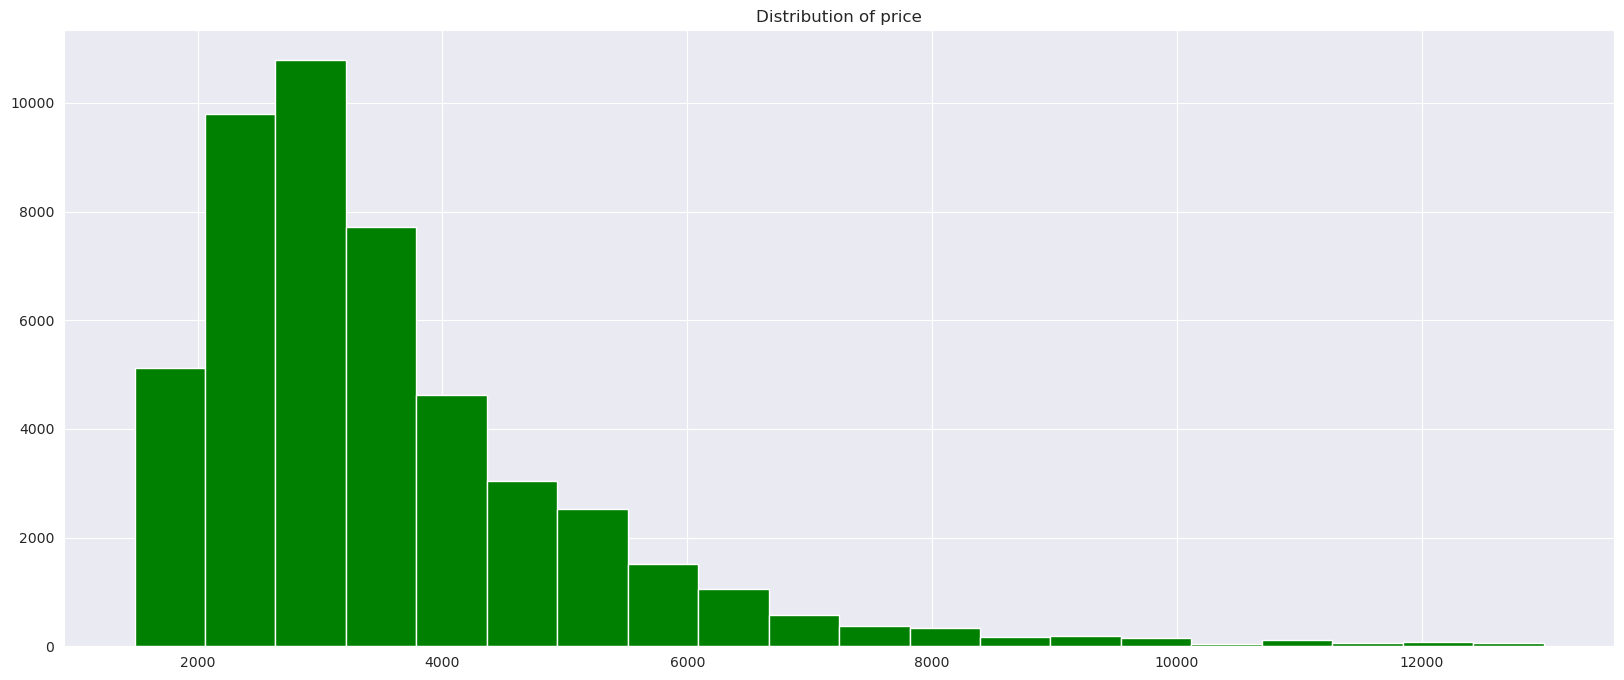

In [271]:
plt.figure(figsize=(20, 8))
plt.title('Distribution of price')
plt.hist(result_df['price'], bins=20, color='green')
plt.show()

In [272]:
log_y = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(X, log_y, test_size=0.2, random_state=21)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train_log = model.predict(X_train)
y_pred_test_log = model.predict(X_test)

y_train_pred = np.expm1(y_pred_train_log)
y_test_pred = np.expm1(y_pred_test_log)
y_train = np.expm1(y_train)
y_test = np.expm1(y_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

model_name = 'linereg log'
if model_name not in result_R2['model'].values:
    result_R2.loc[len(result_R2)] = [model_name, r2_train, r2_test, np.abs(r2_test - r2_train)]
    result_MAE.loc[len(result_MAE)] = [model_name, mae_train, mae_test, np.abs(mae_test - mae_train)]
    result_RMSE.loc[len(result_RMSE)] = [model_name, rmse_train, rmse_test, np.abs(rmse_test - rmse_train)]

In [332]:
X = df_copy.drop(columns=['price'])
y = df_copy['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

Q1 = np.percentile(y_train, 25)
Q3 = np.percentile(y_train, 75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

mask = (y_train > lower) & (y_train < upper)

X_train = X_train[mask]
y_train = y_train[mask]

model = LinearRegression().fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

model_name = 'linereg mask'
if model_name not in result_R2['model'].values:
    result_R2.loc[len(result_R2)] = [model_name, r2_train, r2_test, np.abs(r2_test - r2_train)]
    result_MAE.loc[len(result_MAE)] = [model_name, mae_train, mae_test, np.abs(mae_test - mae_train)]
    result_RMSE.loc[len(result_RMSE)] = [model_name, rmse_train, rmse_test, np.abs(rmse_test - rmse_train)]
elif model_name == result_R2.loc[len(result_R2) - 1, 'model']:
    result_R2.loc[len(result_R2) - 1] = [model_name, r2_train, r2_test, np.abs(r2_test - r2_train)]
    result_MAE.loc[len(result_MAE) - 1] = [model_name, mae_train, mae_test, np.abs(mae_test - mae_train)]
    result_RMSE.loc[len(result_RMSE) - 1] = [model_name, rmse_train, rmse_test, np.abs(rmse_test - rmse_train)]

In [334]:
print_metrics()

Results R2:
                        model     train          test        stable
0             linereg default  0.602062      0.616495      0.014433
1               Ridge default  0.602062      0.616493      0.014431
2               Lasso default  0.601920      0.616227      0.014307
3          ElasticNet default  0.470794      0.475841      0.005047
4         Linear MinMaxScaler  0.602062      0.616495      0.014433
5          Ridge MinMaxScaler  0.602024      0.616333      0.014309
6          Lasso MinMaxScaler  0.601729      0.615800      0.014071
7     ElasticNet MinMaxScaler  0.138556      0.140066      0.001510
8       Linear StandardScaler  0.602062      0.616495      0.014433
9        Ridge StandardScaler  0.602062      0.616495      0.014433
10       Lasso StandardScaler  0.602038      0.616399      0.014361
11  ElasticNet StandardScaler  0.564929      0.576141      0.011212
12          Linear Polynomial  0.576636  -6129.088490   6129.665126
13           Ridge Polynomial  0.578